ada
babbage
curie
text-davinci-003
llama1_7B
llama2_7B
llama1_13B
llama2_13B
llama1_30B
llama1_70B
llama2_70B


/var/folders/4z/0371zfqj5mx0rlct4r3qclfm0000gn/T/ipykernel_82941/3800116730.py:258: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


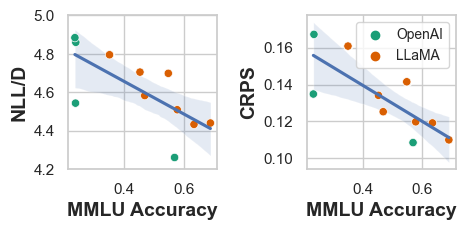

llama2_7B
llama2_7B_chat
llama2_13B
llama2_13B_chat
llama2_70B
llama2_70B_chat


/var/folders/4z/0371zfqj5mx0rlct4r3qclfm0000gn/T/ipykernel_82941/3800116730.py:332: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(
/var/folders/4z/0371zfqj5mx0rlct4r3qclfm0000gn/T/ipykernel_82941/3800116730.py:356: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_yticklabels(
/var/folders/4z/0371zfqj5mx0rlct4r3qclfm0000gn/T/ipykernel_82941/3800116730.py:393: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(


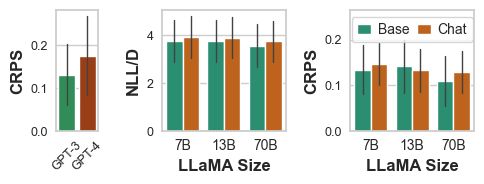

In [4]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

import sys
sys.path.append("..")
from data.small_context import get_datasets
from data.metrics import calculate_crps

sns.set(style="whitegrid", font_scale=1)

old_names = [
    'ada',
    'babbage',
    'curie',
    'text-davinci-003'
]
name_map = {
    # "arima": "ARIMA",
    'ada': "Ada",
    'babbage': "Babbage",
    'curie': "Curie",
    'text-davinci-003':'Davinci',
    "llama1_7B": "LLaMA 7B",
    "llama1_13B": "LLaMA 13B",
    "llama1_30B": "LLaMA 30B",
    "llama1_70B": "LLaMA 70B",
    "llama2_7B": "LLaMA-2 7B",
    "llama2_13B": "LLaMA-2 13B",
    "llama2_70B": "LLaMA-2 70B",
    "llama2_7B_chat": "LLaMA-2 7B (chat)",
    "llama2_13B_chat": "LLaMA-2 13B (chat)",
    "llama2_70B_chat": "LLaMA-2 70B (chat)",
}
hue_order = ['SM-GP','N-BEATS','TCN','N-HiTS','ARIMA','GPT-3']#, 'LLaMA7B', 'LLaMA13B', 'LLaMA30B', 'LLaMA70B']
nlls = defaultdict(list)
crps = defaultdict(list)
mae = defaultdict(list)
datasets = get_datasets()
for dsname,(train,test) in datasets.items():
    pkl_fn = f"../precomputed_outputs/darts/{dsname}.pkl"
    with open(pkl_fn,'rb') as f:
        data_dict = pickle.load(f)

    for model_name in old_names:

        preds = data_dict[model_name]

        if 'NLL/D' not in preds:
            continue
        nll = preds['NLL/D']
        if model_name=='text-davinci-003-tuned':
            model_name='GPT3'

        if type(preds['samples']) == np.ndarray:
            nlls[model_name].append(nll)
            crps[model_name].append(calculate_crps(test.values,preds['samples'][:10],10))
            tmae = np.abs(test.values-preds['median']).mean()/np.abs(test.values).mean()
            mae[model_name].append(tmae)
        else:
            nlls[model_name].append(nll)
            crps[model_name].append(calculate_crps(test.values,preds['samples'].values[:10],10))
            tmae = np.abs(test.values-preds['median']).mean()/np.abs(test.values).mean()
            mae[model_name].append(tmae)

llama_models = [
    "llama1_7B",
    "llama2_7B",
    "llama2_7B_chat",
    "llama1_13B",
    "llama2_13B",
    "llama2_13B_chat",
    "llama1_30B",
    "llama1_70B",
    "llama2_70B",
    "llama2_70B_chat",
]
for dsname,(train,test) in datasets.items():
    for model_name in llama_models:
        if model_name in ['llama2_70B', 'llama2_70B_chat']:
            fn = f'../precomputed_outputs/darts/llama_darts/{model_name}/darts-{dsname}/1.0_0.9_0.99_0.3_3_,_.pkl'
        else:
            fn = f'../precomputed_outputs/darts/llama_darts/{model_name}/darts-{dsname}/0.4_0.9_0.99_0.3_3_,_.pkl'
        with open(fn,'rb') as f:
            data_dict = pickle.load(f)

        preds = data_dict#[model_name]

        if 'NLL/D' not in preds:
            continue
        nll = preds['NLL/D']

        if type(preds['samples']) == np.ndarray:
            nlls[model_name].append(nll)
            crps[model_name].append(calculate_crps(test.values,preds['samples'][:10],10))
            tmae = np.abs(test.values-preds['median']).mean()/np.abs(test.values).mean()
            mae[model_name].append(tmae)
        else:
            nlls[model_name].append(nll)
            crps[model_name].append(calculate_crps(test.values,preds['samples'].values[:10],10))
            tmae = np.abs(test.values-preds['median']).mean()/np.abs(test.values).mean()
            mae[model_name].append(tmae)

nlls = {k:np.array(v) for k,v in nlls.items()}
crps = {k:np.array(v) for k,v in crps.items()}
mae = {k:np.array(v) for k,v in mae.items()}

# Update dataset keys by removing 'Dataset' substring
dataset_keys = [key.replace('Dataset', '') for key in datasets.keys()]

# fig, ax = plt.subplots(1, 1, figsize=(3, 3))
# dfs = [pd.DataFrame({'Dataset':dataset_keys,'NLL/D':v,'Type':k}) for k,v in nlls.items()]
# df = pd.concat(dfs)

# df['Type'] = df['Type'].apply(lambda x: name_map[x])

palette = sns.color_palette('Dark2', len(hue_order))
palette = palette[:2] + palette[3:] + palette[2:3]

mmlu_numbers = {
    'ada': 0.238,
    'babbage': 0.235,
    'curie': 0.237,
    'text-davinci-003': 0.569, 
    'llama1_7B': 0.351,
    'llama2_7B': 0.453,
    # 'llama2_7B_chat': 0.469,
    'llama1_13B': 0.469,
    'llama2_13B': 0.548,
    # 'llama2_13B_chat': 0.469,
    'llama1_30B': 0.578,
    'llama1_70B': 0.634,
    'llama2_70B': 0.689,
    # 'llama2_70B_chat': 0.578,
}

df = []
for k,nll in nlls.items():
    if "chat" in k:
        continue
    print(k)
    _crps, _mae = crps[k], mae[k]
    # print(k,nll)
    # print(list(datasets.keys()))
    # for i in range(len(nll)):
    d = {
        # 'Dataset':list(datasets.keys()),
        'MAE': np.mean(_mae),
        'CRPS': np.mean(_crps),
        'NLL/D': np.mean(nll), #nll[i],#np.mean(nll),
        'Type':k,
        'MMLU Accuracy': mmlu_numbers[k],
    }
    df.append(d)
df = pd.DataFrame(df)


host_name_map = {
    'openai': 'OpenAI',
    'cohere': 'Cohere',
    'forefront': 'Forefront',
    'alephalpha': 'Aleph Alpha',
    'LLaMA': 'LLaMA'
}

def hostify(x):
    if x in ['Ada','Babbage','Curie','Davinci']:
        return 'openai-'+x
    if 'LLaMA' in x:
        return x.replace('LLaMA','LLaMA-')
    return x

df['Type'] = df['Type'].apply(lambda x: name_map[x])
df['Type'] = df['Type'].apply(hostify)
df['host'] = df['Type'].apply(lambda x: host_name_map[x.split("-")[0]])

fig, ax = plt.subplots(1, 2, figsize=(5, 2), gridspec_kw = {'wspace': 0.6})

sns.regplot(
    data=df,
    x='MMLU Accuracy',
    # x='Dataset',
    y='NLL/D',
    order=1,
    # errorbar='se',
    ax=ax[0], 
    scatter_kws={'color':'white'},
)

sns.scatterplot(
    data=df,
    x='MMLU Accuracy',
    y='NLL/D',
    hue='host',
    palette='Dark2',
    ax=ax[0],
)
ax[0].get_legend().remove()
ax[0].set_ylim(4.2, 5.)
ax[0].set_xlabel(ax[0].get_xlabel(), fontsize=14)
ax[0].set_ylabel(ax[0].get_ylabel(), fontsize=14)

sns.regplot(
    data=df,
    x='MMLU Accuracy',
    # x='Dataset',
    y='CRPS',
    order=1,
    # errorbar='se',
    ax=ax[1], 
    scatter_kws={'color':'white'},
)

sns.scatterplot(
    data=df,
    x='MMLU Accuracy',
    y='CRPS',
    hue='host',
    palette='Dark2',
    ax=ax[1],
)

ax[1].set_xlabel(ax[1].get_xlabel(), fontsize=14)
ax[1].set_ylabel(ax[1].get_ylabel(), fontsize=14)

handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(
    handles=handles,
    labels=labels,
    # markerscale=1.5,
    # bbox_to_anchor=(1.05, 1),
    loc='upper right',
    # borderaxespad=0.0,
    columnspacing=0,
    handletextpad=0.5,
    fontsize=10,
    frameon=True,
)

plt.tight_layout()
plt.savefig('outputs/mmlu_scaling.pdf', bbox_inches='tight')
plt.show()


df = []
for k,nll in nlls.items():
    if not "llama" in k:
        continue
    if 'llama1' in k:
        continue
    print(k)
    for _mae, _crps, _nll in zip(mae[k], crps[k], nll):
        df.append({
            # 'Dataset':list(datasets.keys()),
            'MAE': _mae,
            'CRPS': _crps,
            'NLL/D': _nll,
            'Type':k,
            'size': k.split('_')[1],
            'is_chat': 'chat' in k
        })
df = pd.DataFrame(df)


gpt_crps = defaultdict(list)
datasets = get_datasets()
for dsname,(train,test) in datasets.items():
    fn = f'../precomputed_outputs/darts/gpt4/{dsname}.pkl'
    with open(fn,'rb') as f:
        data_dict = pickle.load(f)

    for model_name in data_dict.keys():
        if model_name not in ['text-davinci-003', 'gpt-4']:
            continue

        preds = data_dict[model_name]

        if model_name=='text-davinci-003':
            model_name='GPT-3'
        else:
            model_name='GPT-4'

        if type(preds['samples']) == np.ndarray:
            gpt_crps[model_name].append(calculate_crps(test.values,preds['samples'][:10],10))
        else:
            gpt_crps[model_name].append(calculate_crps(test.values,preds['samples'].values[:10],10))

gpt_df = []
for k,crps in gpt_crps.items():
    for _crps in crps:
        gpt_df.append({
            'CRPS': _crps,
            'Type':k
        })
gpt_df = pd.DataFrame(gpt_df)
gpt_df['CRPS'] = gpt_df['CRPS'].astype('float')


fig, ax = plt.subplots(1, 3, figsize=(5, 2), gridspec_kw = {'width_ratios': [1, 3, 3]})# gridspec_kw = {'wspace': 0.6})

sns.barplot(
    data=df,
    x='size',
    y='NLL/D',
    hue='is_chat',
    palette='Dark2',
    errorbar='se',
    errwidth=1,
    ax=ax[1],
)

ax[1].set_xlabel('LLaMA Size')
ax[1].get_legend().remove()
ax[1].set_yticklabels(
    ax[1].get_yticklabels(), 
    fontsize=9,
)
ax[1].set_xticklabels(
    ax[1].get_xticklabels(), 
    fontsize=10,
)
ax[1].tick_params(pad=0)

sns.barplot(
    data=df,
    x='size',
    y='CRPS',
    hue='is_chat',
    palette='Dark2',
    errorbar='se',
    errwidth=1,
    ax=ax[2],
)

ax[2].set_xlabel('LLaMA Size')
ax[2].set_ylim([0.0, 0.265])
ax[2].get_legend().remove()
ax[2].set_yticklabels(
    ax[2].get_yticklabels(), 
    fontsize=9,
)
ax[2].set_xticklabels(
    ax[2].get_xticklabels(), 
    fontsize=10,
)
ax[2].tick_params(pad=0)

handles, labels = ax[2].get_legend_handles_labels()
labels = ['Base', 'Chat']
ax[2].legend(
    handles, labels, 
    loc='upper center', 
    ncol=2,
    columnspacing=0.5,
    handletextpad=0.5,
    handlelength=1.0,
    fontsize=10,
    frameon=True,
)

palette[0] = "#229c55" #(0.2, 0.6, 0.2)
palette[1] = "#ad3603" #(0.6, 0.2, 0.2)

sns.barplot(
    data=gpt_df,
    x='Type',
    y='CRPS',
    # hue='is_chat',
    palette=palette,
    errorbar='se',
    errwidth=1,
    ax=ax[0],
)

ax[0].set_yticklabels(
    ax[0].get_yticklabels(), 
    fontsize=9,
)
ax[0].set_xticklabels(
    ax[0].get_xticklabels(), 
    fontsize=9,
    rotation=45
)
ax[0].tick_params(pad=0)
ax[0].set_xlabel('')

plt.tight_layout()
plt.savefig('outputs/alignment_effects.pdf', bbox_inches='tight')
plt.show()